<a href="https://colab.research.google.com/github/techwithanirudh/Automatic-Image-Captioning/blob/master/NextWordPred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Credits: https://medium.com/@curiousily/making-a-predictive-keyboard-using-recurrent-neural-networks-tensorflow-for-hackers-part-v-3f238d824218


In [1]:
import os

os.mkdir('/content/NextWordPred')
os.chdir('/content/NextWordPred')

In [2]:
!wget https://raw.githubusercontent.com/techwithanirudh/Shared/6f217f0e2fb11ac4601eb0e0ffc30348ca1021b9/1661-0.txt

--2021-02-05 17:07:12--  https://raw.githubusercontent.com/techwithanirudh/Shared/6f217f0e2fb11ac4601eb0e0ffc30348ca1021b9/1661-0.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 595482 (582K) [text/plain]
Saving to: ‘1661-0.txt’

1661-0.txt          100%[===================>] 581.53K  --.-KB/s    in 0.01s   

2021-02-05 17:07:13 (47.2 MB/s) - ‘1661-0.txt’ saved [595482/595482]



In [3]:
import numpy as np
np.random.seed(42)
import tensorflow as tf
tf.random.set_seed(42)
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation
from keras.layers import LSTM, Dropout
from keras.layers import TimeDistributed
from keras.layers.core import Dense, Activation, Dropout, RepeatVector
from keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import pickle
import sys
import heapq
import seaborn as sns
from pylab import rcParams

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 12, 5

In [4]:
path = '1661-0.txt'
text = open(path).read().lower()
print('corpus length:', len(text))

corpus length: 581889


In [5]:
chars = sorted(list(set(text)))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

print(f'unique chars: {len(chars)}')

unique chars: 73


In [6]:
SEQUENCE_LENGTH = 40
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - SEQUENCE_LENGTH, step):
    sentences.append(text[i: i + SEQUENCE_LENGTH])
    next_chars.append(text[i + SEQUENCE_LENGTH])
print(f'num training examples: {len(sentences)}')

num training examples: 193950


In [7]:
X = np.zeros((len(sentences), SEQUENCE_LENGTH, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

In [8]:
sentences[100]
next_chars[100]
X[0][0]
y[0]
X.shape
y.shape

(193950, 73)

If you want the model you can just download it: https://drive.google.com/file/d/1--6CEy98HcFoocdbRAAQ34_5Y4rxm8Ta/view?usp=sharing

In [9]:
model = Sequential()
model.add(LSTM(128, input_shape=(SEQUENCE_LENGTH, len(chars))))
model.add(Dense(len(chars)))
model.add(Activation('softmax'))

In [10]:
optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(X, y, validation_split=0.05, batch_size=128, epochs=20, shuffle=True).history

Epoch 1/20
1440/1440 [==============================] - 16s 6ms/step - loss: 2.2297 - accuracy: 0.3584 - val_loss: 2.1058 - val_accuracy: 0.4145
Epoch 2/20
1440/1440 [==============================] - 8s 6ms/step - loss: 1.6364 - accuracy: 0.5094 - val_loss: 2.0472 - val_accuracy: 0.4407
Epoch 3/20
1440/1440 [==============================] - 8s 6ms/step - loss: 1.5166 - accuracy: 0.5431 - val_loss: 2.0174 - val_accuracy: 0.4577
Epoch 4/20
1440/1440 [==============================] - 8s 6ms/step - loss: 1.4576 - accuracy: 0.5595 - val_loss: 2.0163 - val_accuracy: 0.4559
Epoch 5/20
1440/1440 [==============================] - 8s 6ms/step - loss: 1.4202 - accuracy: 0.5695 - val_loss: 2.0116 - val_accuracy: 0.4654
Epoch 6/20
1440/1440 [==============================] - 8s 6ms/step - loss: 1.3964 - accuracy: 0.5756 - val_loss: 2.0078 - val_accuracy: 0.4583
Epoch 7/20
1440/1440 [==============================] - 8s 6ms/step - loss: 1.3711 - accuracy: 0.5826 - val_loss: 2.0035 - val_accuracy

In [11]:
model.save('keras_model.h5')
pickle.dump(history, open("history.p", "wb"))

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
!mkdir /content/drive/MyDrive/NextWordPred
!cp /content/NextWordPred/keras_model.h5 /content/drive/MyDrive/NextWordPred/keras_model.h5

Testing


In [14]:
model = load_model('keras_model.h5')
history = pickle.load(open("history.p", "rb"))

In [15]:
plt.plot(history['acc'])
plt.plot(history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

KeyError: ignored

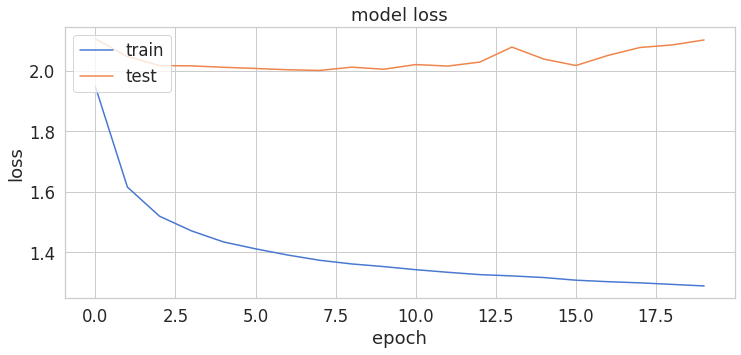

In [16]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

In [17]:
def prepare_input(text):
    x = np.zeros((1, SEQUENCE_LENGTH, len(chars)))
    for t, char in enumerate(text):
        x[0, t, char_indices[char]] = 1.
        
    return x

In [18]:
def sample(preds, top_n=3):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds)
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    
    return heapq.nlargest(top_n, range(len(preds)), preds.take)

In [19]:
def predict_completion(text):
    original_text = text
    generated = text
    completion = ''
    while True:
        x = prepare_input(text)
        preds = model.predict(x, verbose=0)[0]
        next_index = sample(preds, top_n=1)[0]
        next_char = indices_char[next_index]
        text = text[1:] + next_char
        completion += next_char
        
        if len(original_text + completion) + 2 > len(original_text) and next_char == ' ':
            return completion

In [20]:
quotes = [
    "It is not a lack of love, but a lack of friendship that makes unhappy marriages.",
    "That which does not kill us makes us stronger.",
    "I'm not upset that you lied to me, I'm upset that from now on I can't believe you.",
    "And those who were seen dancing were thought to be insane by those who could not hear the music.",
    "It is hard enough to remember my opinions, without also remembering my reasons for them!"
]

In [23]:
for q in quotes:
    seq = q[:40].lower()
    print(seq)
    print(predict_completion(seq))
    print()

it is not a lack of love, but a lack of 
the 

that which does not kill us makes us str
eam 

i'm not upset that you lied to me, i'm u
pon 

and those who were seen dancing were tho
ugh 

it is hard enough to remember my opinion
 



In [ ]:
import shutil

shutil.rmtree('/content/NextWordPred')